# Time Series Analysis - S&P 500 Index - 10 years 

The main goal of the Capstone Project is the evaluation of hybrid and stand-alone time-series predictive models using stock market data, such as SARIMA and Neural Networks (NN). 
In order to develop such models, the work will be carried by performing an analysis and meeting models requirements and assumptions. In addition, any pre-processing step or transformations would be exactly the same for all, focusing on consistency and fairness across every approach when comparing the results.   

**The present and first Jupyter will be composed by**: 

- Importing the data from Yahoo Finance; 
- Pre-Processing;
- EDA;
- Time Series Analysis; 


In [2]:
# Importing the necessary libraries for the project. 
import pandas as pd 
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
from scipy import stats
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import ParameterSampler
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid

import warnings # filter warnings
warnings.filterwarnings('ignore')

The selected source is Yahoo Finances:

- Integration with Python;
- Open-Source data;
- Reliable Source;

The proposed period for the analysis in the project is 10 years of daily data. 

In [4]:
# Defines ticker symbol for S&P 500 index.
ticker_symbol = "^GSPC"

# Fetch historical data.
sp500_data = yf.download(ticker_symbol, start="2013-12-31", end="2023-12-31")

[*********************100%%**********************]  1 of 1 completed


# First Stage of Pre-Processing and EDA

- The analysis will be carried out using the closing index of the trading day.

In [6]:
# Selecting only the Close column (closing prices).
df = sp500_data['Close']

In [7]:
df.info() # Features and Info of the dataset.

<class 'pandas.core.series.Series'>
DatetimeIndex: 2517 entries, 2013-12-31 to 2023-12-29
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
2517 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [8]:
df.head() # First five rows of the dataset.

Date
2013-12-31    1848.359985
2014-01-02    1831.979980
2014-01-03    1831.369995
2014-01-06    1826.770020
2014-01-07    1837.880005
Name: Close, dtype: float64

In [9]:
df.shape # Shape of the dataset (rows X columns). 

(2517,)

- The dataset, a time-series data, is composed by the Date (Datetime Index) and the Close (daily closing index). The series presents 2517 observations. 

In [11]:
df.describe() # Descriptive Statistics of the closing index.

count    2517.000000
mean     3005.423258
std       901.454132
min      1741.890015
25%      2124.199951
50%      2798.030029
75%      3906.709961
max      4796.560059
Name: Close, dtype: float64

- Further comments on statistical properties will be given after imputation technique. 

In [13]:
# Check for missing values.
missing_values = df.isnull().sum()

# Print the number of missing values for each column.
print("Missing values:")
print(missing_values)

Missing values:
0


- As the count of statistics was the same as the number of observations, no missing values at this stage.  

In [15]:
# Check the frequency of the time series.
frequency = pd.infer_freq(df.index)

print("Frequency of the time series:", frequency) # Prints the frequency of the series.

Frequency of the time series: None


No frequency was detected in the time-series, thus business days ('b') will be the selected, due to the needs of the project.  
- Aligns with the chacteristics of the data (Stock market data), which is only open on business days. 


In [17]:
df = df.asfreq('b') # Sets the frequency to business days.

- Without any frequency, the original set did not included holidays and by setting to business days, it will generate nan values. 

In [19]:
# Check for missing values.
missing_values = df.isnull().sum()

# Print the number of missing values for each column.
print("Missing values:")
print(missing_values)

Missing values:
92


- After setting the new frequency, the series presents 92 missing values (number of holidays throughout 10 years of interval).

In [21]:
# Checking if there's any consecutive missing values in the Close indexes. 
# Converting NaN checks to integers (1 for True, 0 for False).
nan_series = df.isna().astype(int)

# Rolling window size 3 and sum to identify consecutive NaNs.
consecutive_nans = nan_series.rolling(window=3).sum() == 3

# Check for any occurrence of more than two consecutive NaNs.
has_consecutive_nans = consecutive_nans.any()

print(f"Two consecutive NaNs in 'Close' column? {has_consecutive_nans}")

Two consecutive NaNs in 'Close' column? False


- Between the period of 10 years, 92 holidays were added (no values).
- No consecutive missing values (two holidays in a sequence does not exists). 
- Assuming that the close value of the last trading day will maintain until the following trading day.

Many options can be applied to fill the missing values (holidays) and each one of them have a trade off of pros and cons. Techniques using the next opening day to fill the previous, linear regression and others (depending on the performance). The selected approach to handle the missing values is the foward fill and the reasons relies on:

The S&P500 index does not suffers any change when the market is closed;
- It can reduce the amount of noise by not adding artificial data;
- It represents more accurate real-world scenario;

Other options such as back-fill using the open index of the next day could be considered. On one hand can present events that might impact the stock market, on the other hand it can introduce bias to the models, by "seing" future data.

In [23]:
# Forward fill NaN values in the 'Close' column.
df.fillna(method='ffill', inplace=True)

# Display the updated DataFrame with forward filled values.
display(df)

Date
2013-12-31    1848.359985
2014-01-01    1848.359985
2014-01-02    1831.979980
2014-01-03    1831.369995
2014-01-06    1826.770020
                 ...     
2023-12-25    4754.629883
2023-12-26    4774.750000
2023-12-27    4781.580078
2023-12-28    4783.350098
2023-12-29    4769.830078
Freq: B, Name: Close, Length: 2609, dtype: float64

In [24]:
# Check for missing values.
missing_values = df.isnull().sum()

# Print the number of missing values for each column.
print("Missing values:")
print(missing_values)

Missing values:
0


- After applying the forward-fill, the previous code shows that it was sucessfull, resulting in zero missing values. 

In [26]:
# Get summary statistics
summary_stats = df.describe()

# Find the date of highest and lowest close price
peak_date = df.idxmax()
lowest_date = df.idxmin()

# Calculate monthly returns
monthly_returns = df.resample('M').ffill().pct_change().dropna()

# Output of metrics.
print("Summary Statistics:\n", summary_stats)
print("Peak Close Price Date:", peak_date, "Value:", df[peak_date])
print("Lowest Close Price Date:", lowest_date, "Value:", df[lowest_date])

Summary Statistics:
 count    2609.000000
mean     3005.472863
std       901.733128
min      1741.890015
25%      2124.199951
50%      2793.899902
75%      3902.620117
max      4796.560059
Name: Close, dtype: float64
Peak Close Price Date: 2022-01-03 00:00:00 Value: 4796.56005859375
Lowest Close Price Date: 2014-02-03 00:00:00 Value: 1741.8900146484375


The statistical properties of the index suffered small changes compared to the scale of the data.

- Count: Originally the dataset was composed by 2517 rows and had an increased of 92, totalizing 2609 observations. 
- Mean: After the imputation the mean increased only 0.049 (3005.47), indicating that the central tendency did not suffer any change. 
- Standard Deviation (std): After handling the missing values, the std was not impacted (increased of 0.27). Also, the value 901.7 indicates that the index shows significant variability.

Between the years of collected data, the highest recorded index was in 3 of January of 2022 at 4796.56 and the lowest in 3 of February of 2014 at 17.41.89.

In [28]:
# Filter and display the specified rows by their date
rows_to_display = df.loc[['2014-01-28', '2014-01-29', '2014-01-30', '2014-01-31', '2014-02-03']]

# Display the selected rows
print(rows_to_display)


Date
2014-01-28    1792.500000
2014-01-29    1774.199951
2014-01-30    1794.189941
2014-01-31    1782.589966
2014-02-03    1741.890015
Name: Close, dtype: float64


## S&P500 Visual Analysis

Statistical features along with visualizations will be generated to deepen the analysis. 
First the the observations will be extracted from the "original format" of the S&P500 index and later percentage change will be used to enhance the examination. In addition, pct change will help analysing the series volatility. 

In [30]:
# A copy will be created in a dataframe format to help the generation of plots.
# Creates a copy and converts the Series to a DataFrame.
df1 = df.to_frame()

# Creates a year column for grouping.
df1['Year'] = df1.index.year

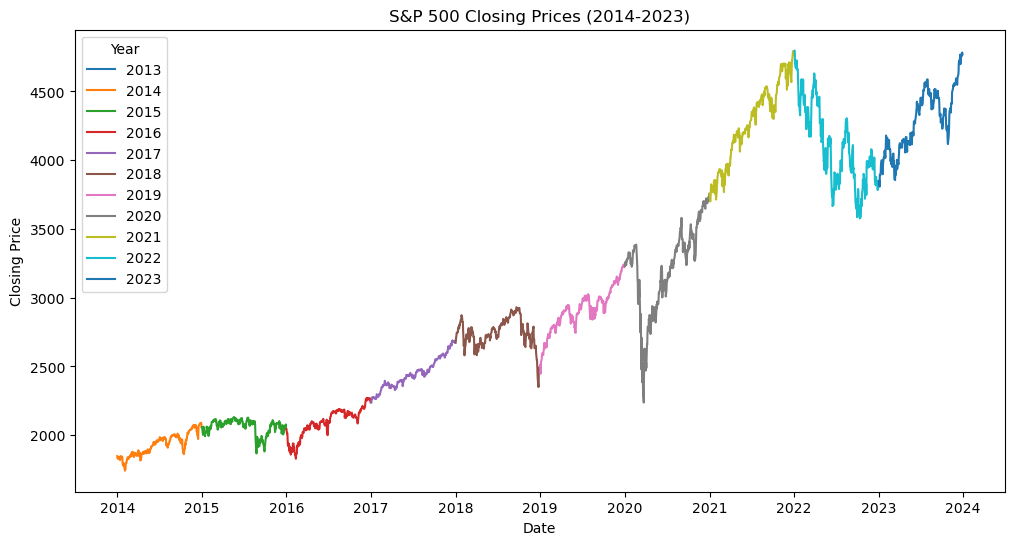

In [31]:
# Line Plot per Year
plt.figure(figsize=(12, 6)) # Sets fig size.
# Sets  the lineplot where the colors are based on the yeard, following the tab10 palette, providing clarity to the observer. 
sns.lineplot(data=df1, x=df1.index, y='Close', hue='Year', palette='tab10') 
plt.title('S&P 500 Closing Prices (2014-2023)') # Sets title.
plt.xlabel('Date') # Add label.
plt.ylabel('Closing Price') # Add label.
plt.legend(title='Year') # Adds legend (years). 
plt.show() # Display the fig. 

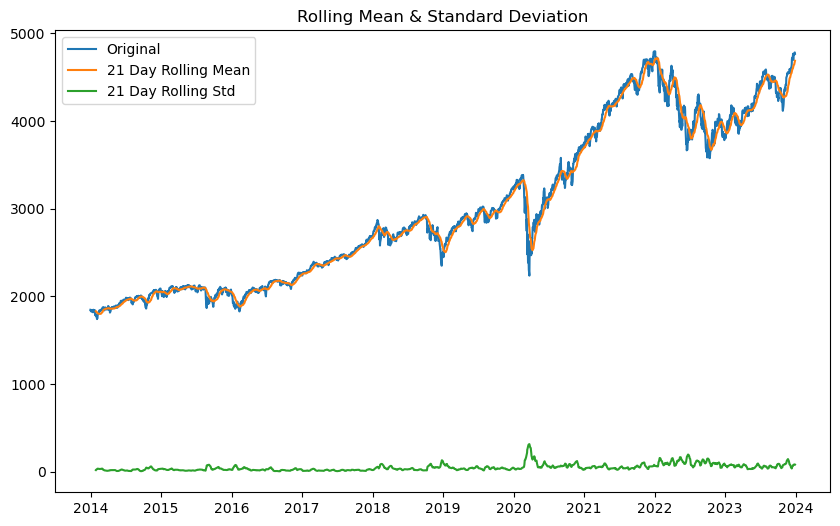

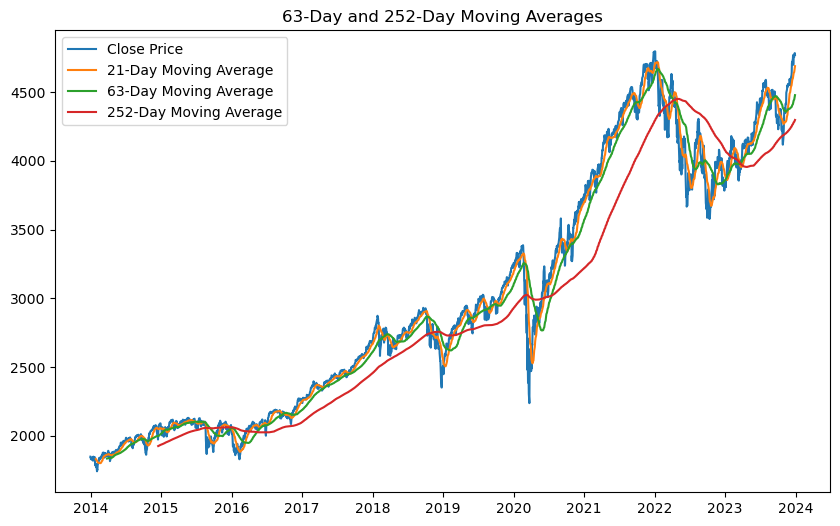

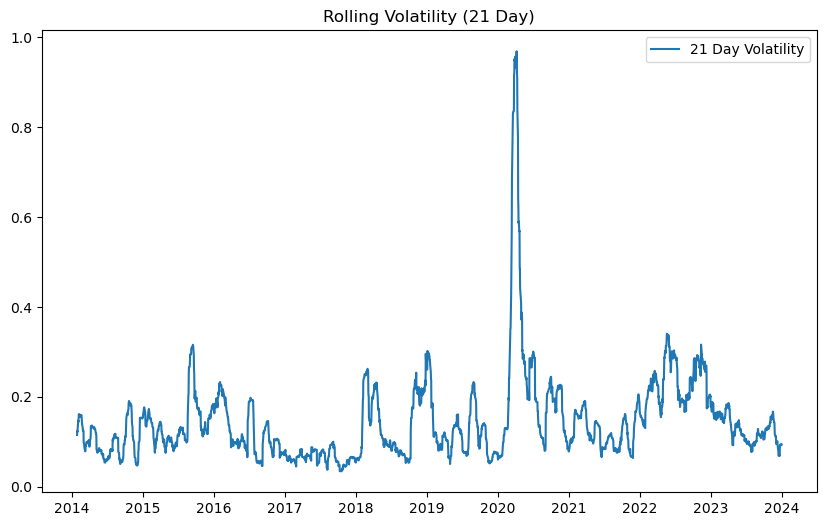

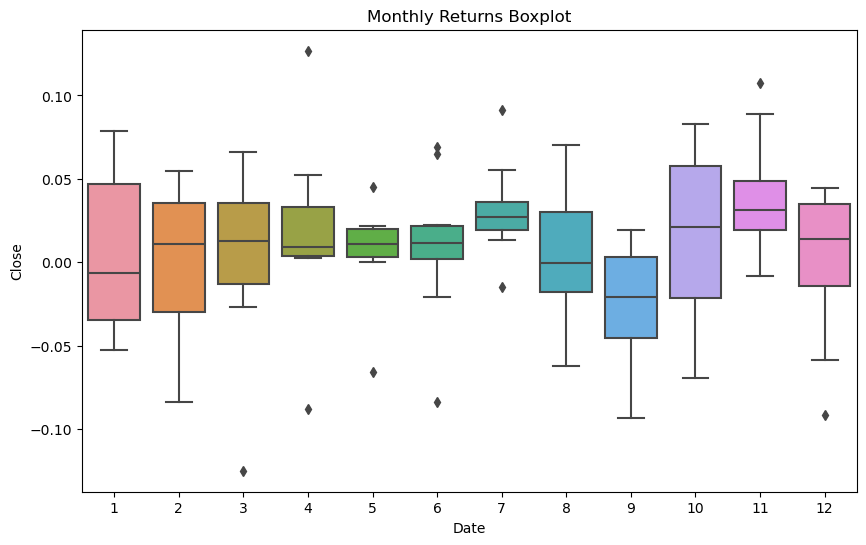

In [32]:
# Rolling Statistics and Moving Averages
rolling_mean_21 = df.rolling(window=21).mean()
rolling_std_21 = df.rolling(window=21).std()

# Long-term moving averages
rolling_mean_21 = df.rolling(window=21).mean()
rolling_mean_63 = df.rolling(window=63).mean()
rolling_mean_252 = df.rolling(window=252).mean()

# Volatility Analysis (Rolling volatility with a 30-day window)
volatility_21 = df.pct_change().rolling(window=21).std() * (252**0.5)  # Annualized volatility

# Seasonality Analysis (Monthly seasonality)
monthly_seasonality = df.groupby(df.index.month).mean()

# Visualizations

# Plotting rolling statistics
plt.figure(figsize=(10,6))
plt.plot(df, label='Original')
plt.plot(rolling_mean_21, label='21 Day Rolling Mean')
plt.plot(rolling_std_21, label='21 Day Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

# Plot moving averages
plt.figure(figsize=(10,6))
plt.plot(df, label='Close Price')
plt.plot(rolling_mean_21, label='21-Day Moving Average')
plt.plot(rolling_mean_63, label='63-Day Moving Average')
plt.plot(rolling_mean_252, label='252-Day Moving Average')
plt.title('63-Day and 252-Day Moving Averages')
plt.legend()
plt.show()

# Plot volatility
plt.figure(figsize=(10,6))
plt.plot(volatility_21, label='21 Day Volatility')
plt.title('Rolling Volatility (21 Day)')
plt.legend()
plt.show()

# Boxplot to detect outliers in monthly returns
plt.figure(figsize=(10,6))
sns.boxplot(x=monthly_returns.index.month, y=monthly_returns)
plt.title('Monthly Returns Boxplot')
plt.show()

Lineplot:
- The index presents an upward trend, the figures shows a long-term growth of the stocks. 
- In the recorded period, volatility is present, especially during crisis that can affect the economy (Health crisis started in 2019).
- The lineplot also does not show clear patterns. (indication of cyclical pattern, instead of seasonal).  

Rolling Statistics: 
- Shows a an upward trend with a huge dip during 2020 (Covid pandemic).

Rolling Volatility:
- It had a massive spike during the year of 2020 and returning to "normality" in the following year.
<b>- It could present great threat to forecasting models, periods with high volatility might cause bad performance.</b>

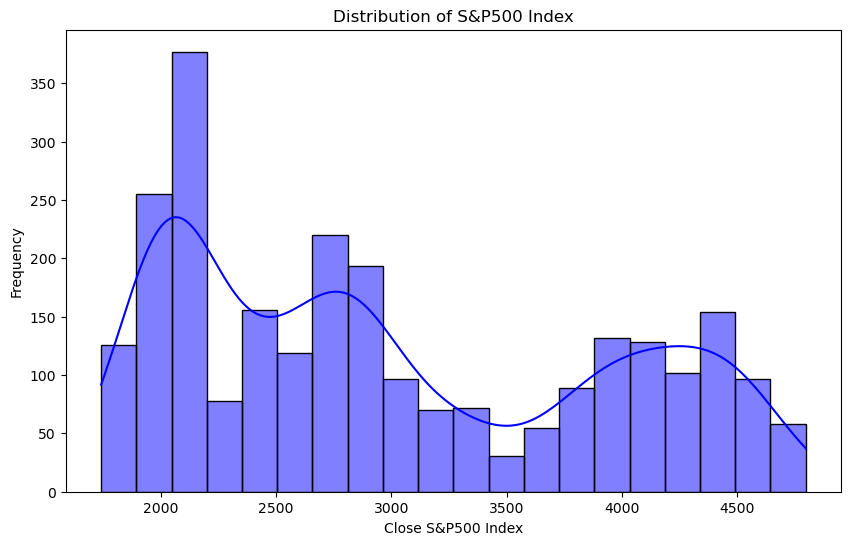

In [34]:
# Distribution plot of Close prices
plt.figure(figsize=(10, 6)) # Set fig size.
sns.histplot(df, bins=20, kde=True, color='blue') # Set bin size and color, add kde curve. 
plt.title('Distribution of S&P500 Index') # Add title.
plt.xlabel('Close S&P500 Index') # X-label.
plt.ylabel('Frequency') # Y-label.
plt.show() # Display the fig. 

- The histogram indicates that the index presents multimodal characteristics, where the KDE curve shows three different peaks. Despite trying different number of bins, multiple peaks were still present.
- During the recorded period, lower values (between 2000 and 3000) are more frequente than the higher values, indicating a right-skewed distribution.

**Obs**.: Models that follows the assumption that the data is normally distruibuted could present challenges. 

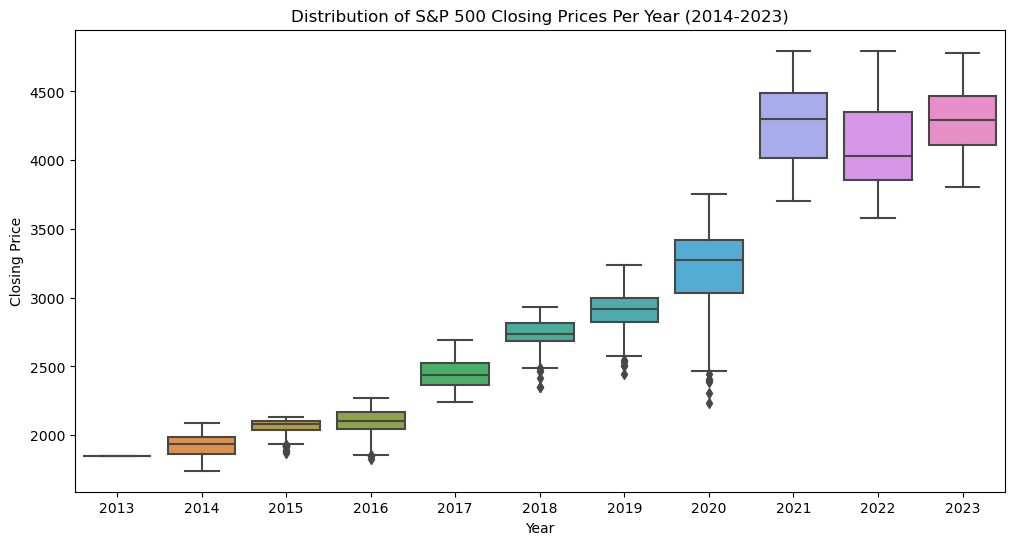

In [36]:
# Box Plot per Year
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='Close', data=df1)
plt.title('Distribution of S&P 500 Closing Prices Per Year (2014-2023)')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.show()

The Boxplot per year shows that: 
- Like the lineplot it presents a upward trend. 
- The presence of outliers, especially in times of economical turmoil like the Covid Pandemic. High volatility.

**Note**: Outliers is a real threat for the models, the first attempt could be performed without any further processing step, just relying on techniques that would be applied in the forecasting models, such stationarity or scaling. In addition, if models performs badly, an extra step can be applied to reduce their impact.

### Seasonal Decomposition (Without transformation)

Both models, additive and multiplicative will be performed to check which one will better capture trends and seasonality (by observing the randomness of residuals. 

Seasonal Decomposition with Period = 252


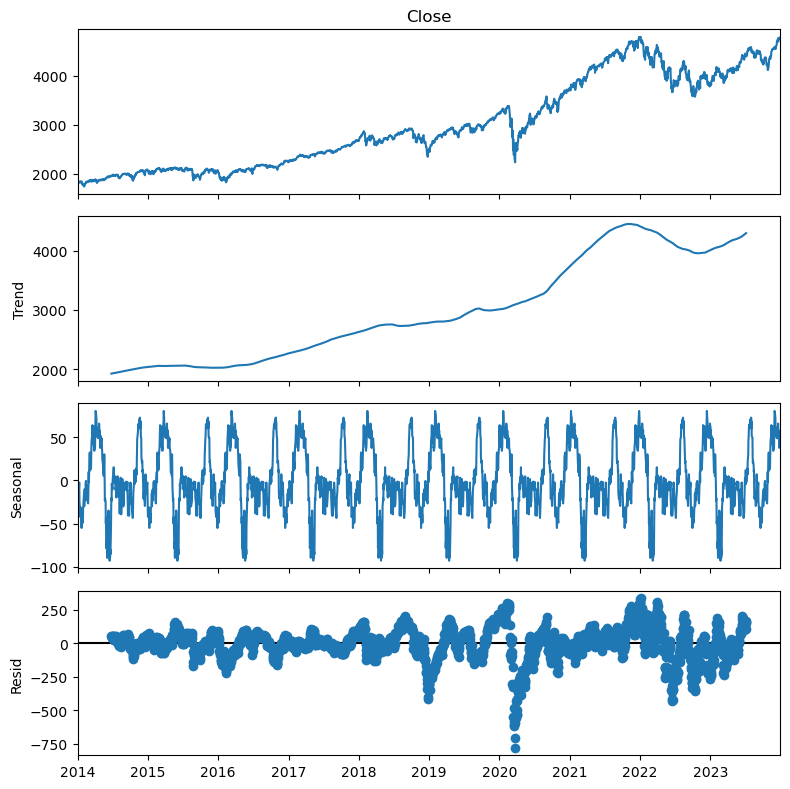

Seasonal Decomposition with Period = 126


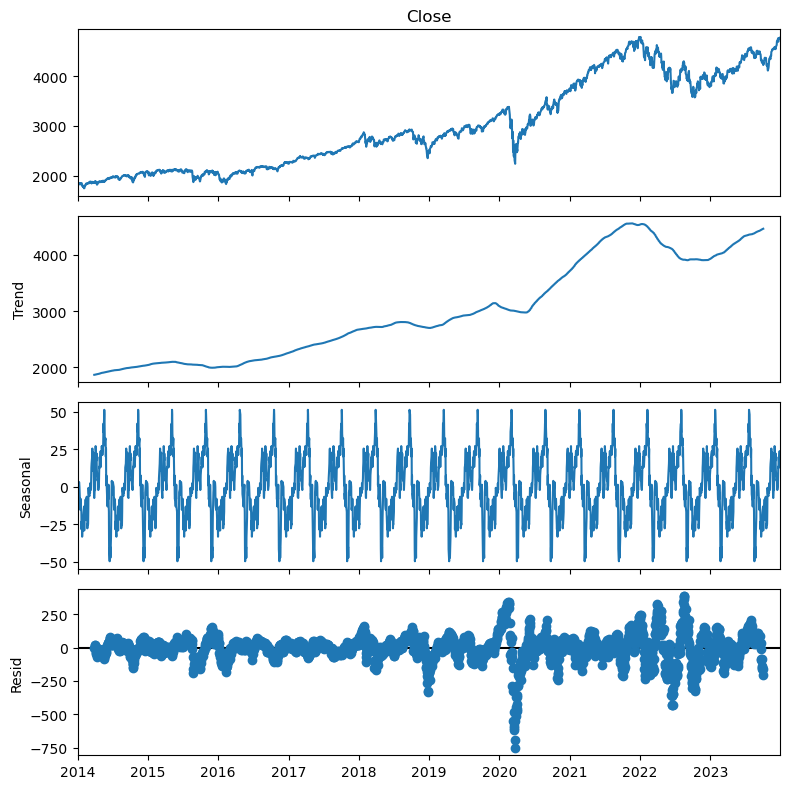

Seasonal Decomposition with Period = 20


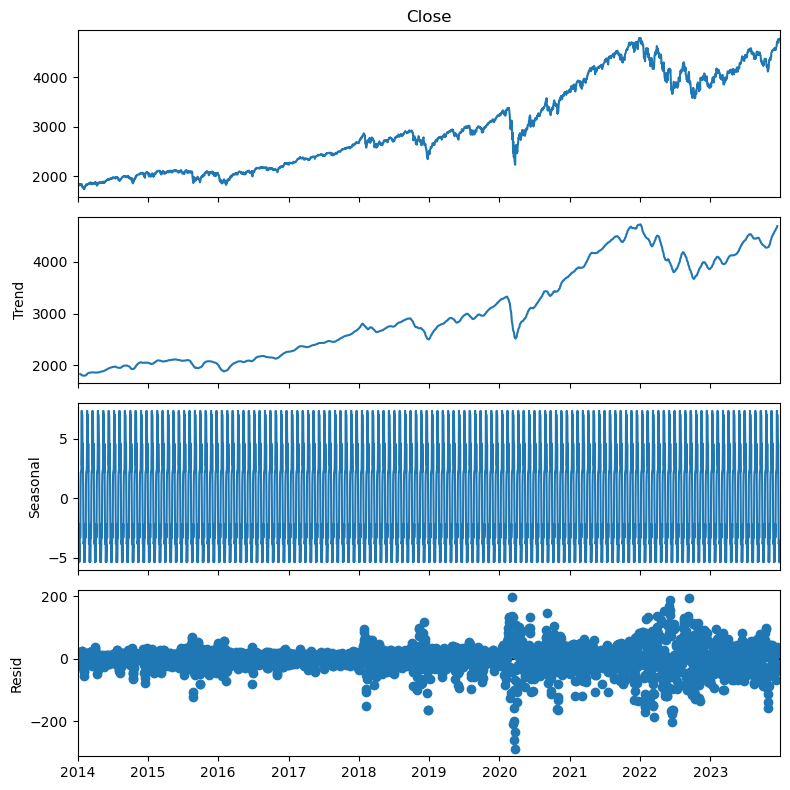

Seasonal Decomposition with Period = 5


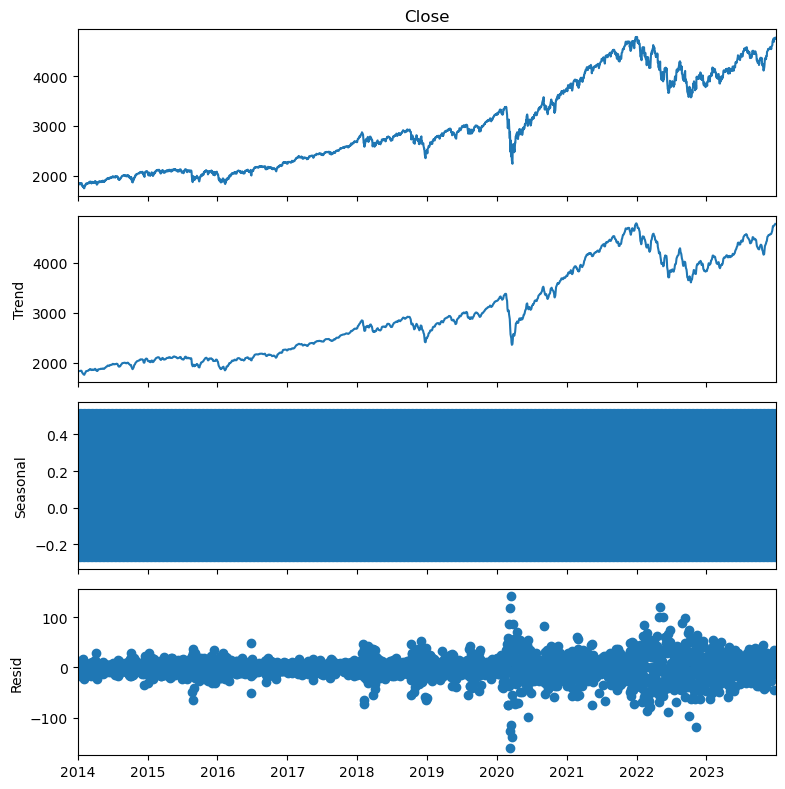

In [39]:
# Seasonal decompositions with different periods.
periods = [252, 126, 20, 5]  # Six months, Quarterly, Monthly, Weekly
# Function to generate the plots for all periods.
for period in periods:
    decompositions = seasonal_decompose(df, model='additive', period=period)

    # Plotting the components of the decomposition
    plt.rcParams.update({'figure.figsize': (8,8)})
    print(f"Seasonal Decomposition with Period = {period}")
    decompositions.plot()
    plt.show()

Seasonal Decomposition with Period = 252


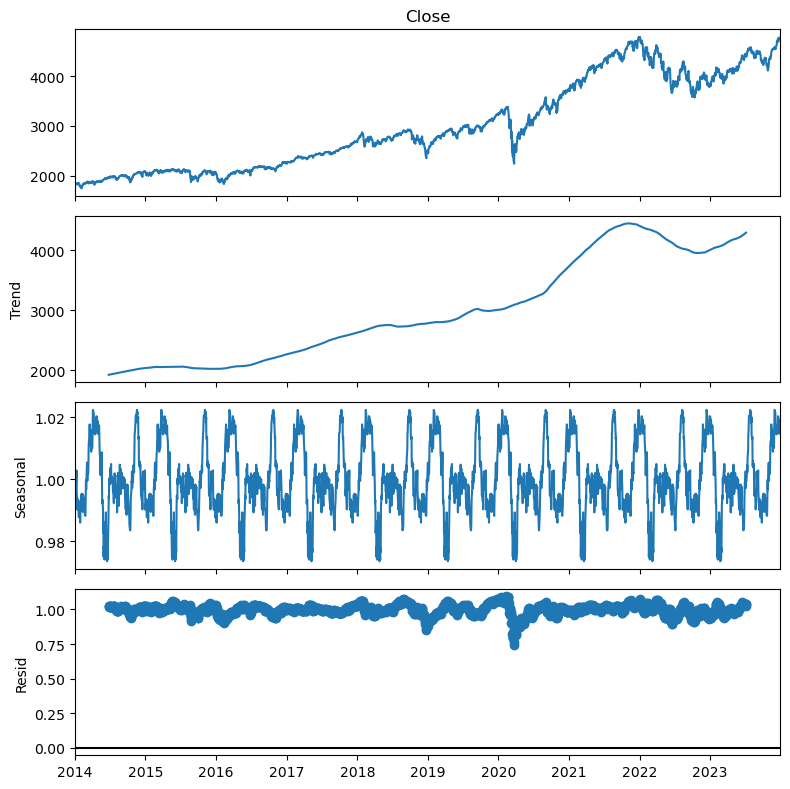

Seasonal Decomposition with Period = 126


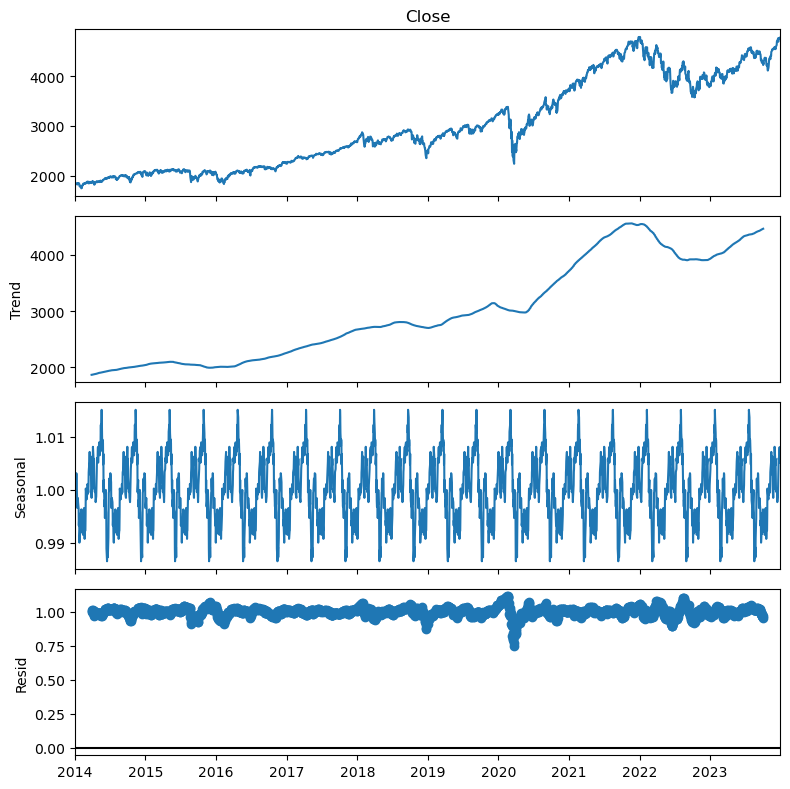

Seasonal Decomposition with Period = 20


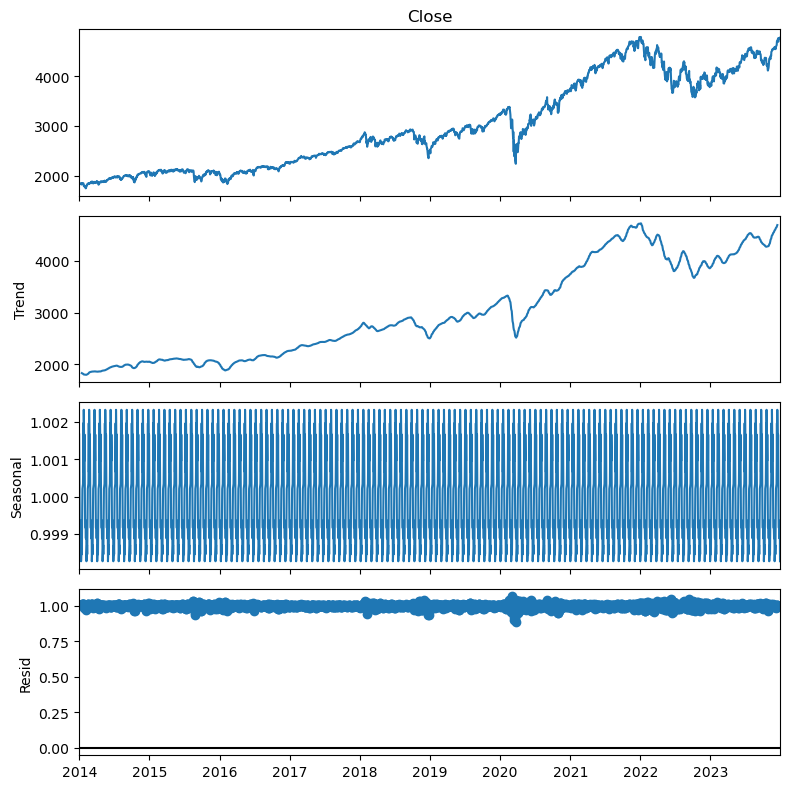

Seasonal Decomposition with Period = 5


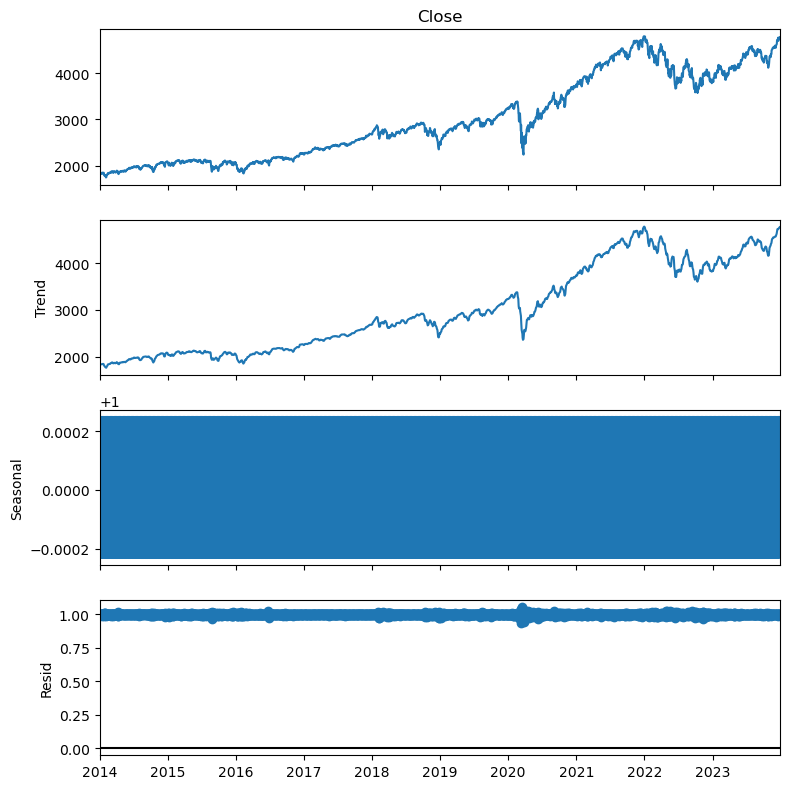

In [40]:
# Seasonal decompositions with different periods.
periods = [252, 126, 20, 5]  # Six months, Quarterly, Monthly, Weekly
# Function to generate the plots for all periods.
for period in periods:
    decompositions = seasonal_decompose(df, model='multiplicative', period=period)

    # Plotting the components of the decomposition
    plt.rcParams.update({'figure.figsize': (8,8)})
    print(f"Seasonal Decomposition with Period = {period}")
    decompositions.plot()
    plt.show()

According to the seasonal decompose (additive and multiplicative): 

- Both models shows a clear upward trend, indicating constant growth overtime, but presenting big drops, like when Covid-19 appeared (external events). 
- Seasonal variations is also observable when applying the multiplicative model. So, indicating that the seasonal variation of the S&P500 is not constant throughout time, but it might change proportionaly with the series. 
- Residuals in the multiplicative approach is less random and more aligned with the axis 1. Meanwhile, the additive has the residuals less aligned with its zero axis. Thus, the multiplicative method was able to better capture the trend and seasonal effects than the additive. 

Therefore, the decomposition of the series were better represented byt the multiplicative approach, meaning that more complex models like neural networks that could capture seasonal variations and likely yielding better performance.   

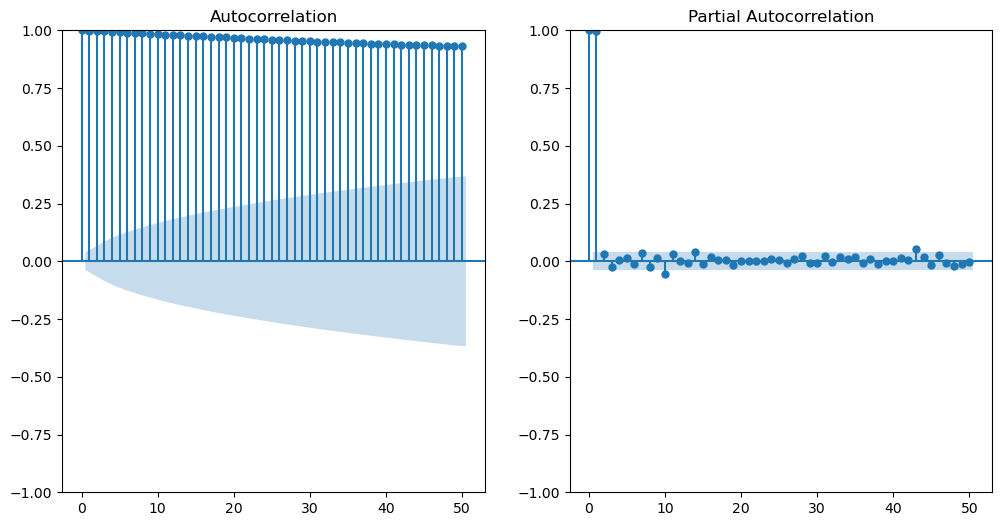

In [42]:
# ACF and PACF of log returns
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(df, ax=plt.gca(), lags=50) # sets the acf plot. 
plt.subplot(122)
plot_pacf(df, ax=plt.gca(), lags=50) # sets the pacf plot. 
plt.show() # shows the plots

- The ACF correlation plot shows a strong correlation between its past values, in which can indicate that the series might not be stationary, because of the depency of previous values.
- The PACF shows that after the second lag the it drops to the confidence of interval. This information would be for auto-regressive models, where its order could be initially tested at 1 or 2.  

In [44]:
# ADF Test
result = adfuller(df, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.274939693479533
p-value: 0.9289793936532919
Critial Values:
   1%, -3.4328724587241686
Critial Values:
   5%, -2.862654426799674
Critial Values:
   10%, -2.567363249505311

KPSS Statistic: 7.951934
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


Both tests shows that the series is not stationary. The ADF test determined that the p-value is way above 0.05, so as the critical value is greater than the 10, 5 and 1%. The KPSS test also shows the the statistic value is way above the others and the p-value has a low value of 0.01. Therefore, to perform time series forecasting, the index will have to be transformed to achieve stationarity.
A couple of techniques will be applied (this is the case of autoregressive models, Neural Networks are able  to handle non-stationary data): 
- Log plus first order differencing: A model that is additive over time (a positive point for financial data) and has great chances to achieve stationarity. 
- Seasonal Differencing: With seasonal patters, the approach will attempt to remove seasonal patterns to achieve the objective. 


The approches will be evaluated in the forecasting stage, pointing which one has the lower metric scores. In addition, looking at consitency the data and pre-processing steps will be the same as performed in the present analysis. 

# Second Stage of Pre-Processing and EDA 

It was identified that the models could suffer from overfitting and this could be the high volatility and the presence of outliers (boxplots).
So, the first step will handle stationarity and followed by winsorization, a technique that will cap extreme values. The "cut-off" values can be set through its quantile parameters and in the case of this project the chosen values will be 0.1 and 0.9, an agressive selection due to the high number of outliers. 

In addition, it was noticed that 2020:
- Is an "extreme" year, where its volatility is very high.
- If winsozisation is applied using the quantiles of the entire dataset the values of 2020 will not be "adjusted properly", because the values of the year fall between the 0.1/0.9 setting.

Therefore, the approach will be applied using the quantiles per year and later saved to be tested if the technique has any impact dealing with outliers and possibly volatility.  

In [47]:
# Applying log transformation
log = np.log(df) 

# First-order differencing to remove trend
log_diff = log.diff().dropna()

In [48]:
log_diff.head()

Date
2014-01-01    0.000000
2014-01-02   -0.008901
2014-01-03   -0.000333
2014-01-06   -0.002515
2014-01-07    0.006063
Freq: B, Name: Close, dtype: float64

In [49]:
# Get summary statistics
summary_stats = log_diff.describe()

# Find the date of highest and lowest close price
peak_date = log_diff.idxmax()  # Date of highest close price
lowest_date = log_diff.idxmin()  # Date of lowest close price

# Output summary statistics and the highest and lowest close prices
print("Summary Statistics:\n", summary_stats)
print("Peak Close Price Date:", peak_date, "Value:", log_diff.loc[peak_date])
print("Lowest Close Price Date:", lowest_date, "Value:", log_diff.loc[lowest_date])

Summary Statistics:
 count    2608.000000
mean        0.000364
std         0.011013
min        -0.127652
25%        -0.003545
50%         0.000302
75%         0.005250
max         0.089683
Name: Close, dtype: float64
Peak Close Price Date: 2020-03-24 00:00:00 Value: 0.08968323251796306
Lowest Close Price Date: 2020-03-16 00:00:00 Value: -0.12765219747281709


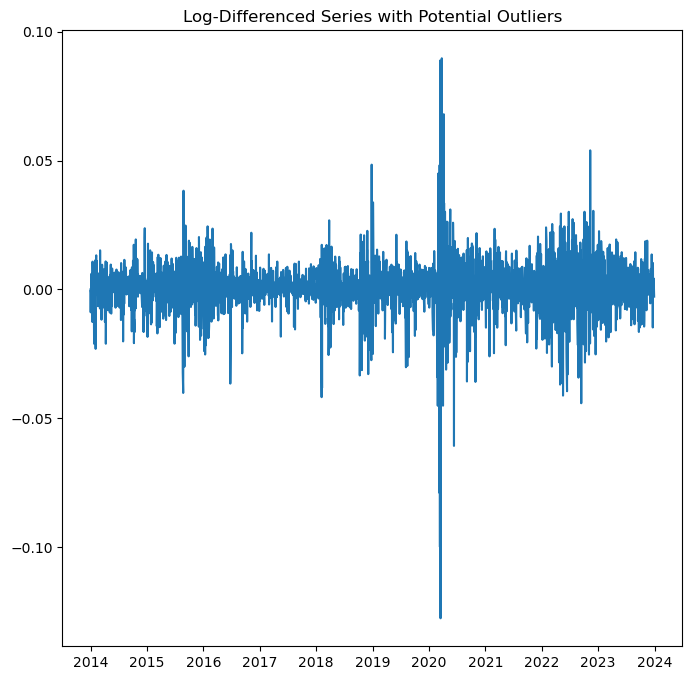

Date
2015-08-24   -0.040211
2015-08-26    0.038291
2016-06-24   -0.036581
2018-02-05   -0.041843
2018-02-08   -0.038259
2018-10-10   -0.033416
2018-12-04   -0.032900
2018-12-26    0.048403
2019-01-04    0.033759
2020-02-24   -0.034088
2020-02-27   -0.045168
2020-03-02    0.045011
2020-03-04    0.041336
2020-03-05   -0.034511
2020-03-09   -0.079010
2020-03-10    0.048215
2020-03-11   -0.050103
2020-03-12   -0.099945
2020-03-13    0.088808
2020-03-16   -0.127652
2020-03-17    0.058226
2020-03-18   -0.053222
2020-03-20   -0.044328
2020-03-24    0.089683
2020-03-26    0.060544
2020-03-27   -0.034268
2020-04-01   -0.045146
2020-04-06    0.067968
2020-04-08    0.033489
2020-06-11   -0.060753
2020-09-03   -0.035758
2020-10-28   -0.035926
2022-04-29   -0.036959
2022-05-05   -0.036301
2022-05-18   -0.041234
2022-06-13   -0.039540
2022-06-16   -0.033052
2022-08-26   -0.034269
2022-09-13   -0.044199
2022-11-10    0.053953
Name: Close, dtype: float64


In [50]:
# Plot the transformed series
plt.plot(log_diff)
plt.title('Log-Differenced Series with Potential Outliers')
plt.show()

# Z-score based outlier detection on transformed series
z_scores = (log_diff - log_diff.mean()) / log_diff.std()
outliers = log_diff[np.abs(z_scores) > 3]
print(outliers)

In [51]:
# Calculate the 1st and 99th percentiles
lower_limit = np.percentile(log_diff, 1)
upper_limit = np.percentile(log_diff, 99)

# Apply winsorization by clipping the values
log_diff_winso = np.clip(log_diff, lower_limit, upper_limit)

# If you want to work with Pandas
log_diff_winso = pd.Series(log_diff_winso)

In [52]:
# Get summary statistics
summary_stats = log_diff_winso.describe()

# Find the date of highest and lowest close price
peak_date = log_diff_winso.idxmax()  # Date of highest close price
lowest_date = log_diff_winso.idxmin()  # Date of lowest close price

# Output summary statistics and the highest and lowest close prices
print("Summary Statistics:\n", summary_stats)
print("Peak Close Price Date:", peak_date, "Value:", log_diff_winso.loc[peak_date])
print("Lowest Close Price Date:", lowest_date, "Value:", log_diff_winso.loc[lowest_date])

Summary Statistics:
 count    2608.000000
mean        0.000352
std         0.009536
min        -0.032877
25%        -0.003545
50%         0.000302
75%         0.005250
max         0.025807
Name: Close, dtype: float64
Peak Close Price Date: 2015-08-26 00:00:00 Value: 0.025807043515658816
Lowest Close Price Date: 2015-08-24 00:00:00 Value: -0.032876519187629155


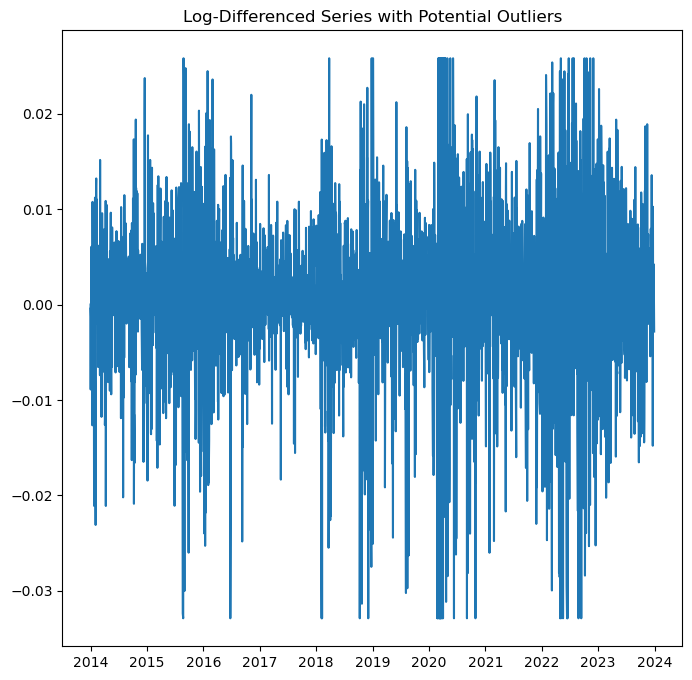

Date
2015-08-21   -0.032369
2015-08-24   -0.032877
2015-09-01   -0.030023
2016-06-24   -0.032877
2018-02-05   -0.032877
2018-02-08   -0.032877
2018-10-10   -0.032877
2018-10-24   -0.031351
2018-12-04   -0.032877
2019-08-05   -0.030230
2019-08-14   -0.029730
2020-02-24   -0.032877
2020-02-25   -0.030748
2020-02-27   -0.032877
2020-03-03   -0.028510
2020-03-05   -0.032877
2020-03-09   -0.032877
2020-03-11   -0.032877
2020-03-12   -0.032877
2020-03-16   -0.032877
2020-03-18   -0.032877
2020-03-20   -0.032877
2020-03-23   -0.029732
2020-03-27   -0.032877
2020-04-01   -0.032877
2020-04-21   -0.031155
2020-05-01   -0.028460
2020-06-11   -0.032877
2020-09-03   -0.032877
2020-10-28   -0.032877
2022-03-07   -0.029963
2022-04-26   -0.028550
2022-04-29   -0.032877
2022-05-05   -0.032877
2022-05-09   -0.032562
2022-05-18   -0.032877
2022-06-10   -0.029542
2022-06-13   -0.032877
2022-06-16   -0.032877
2022-08-26   -0.032877
2022-09-13   -0.032877
2022-10-07   -0.028403
Name: Close, dtype: float64


In [53]:
# Plot the transformed series
plt.plot(log_diff_winso)
plt.title('Log-Differenced Series with Potential Outliers')
plt.show()

# Z-score based outlier detection on transformed series
z_scores = (log_diff_winso - log_diff_winso.mean()) / log_diff_winso.std()
outliers1 = log_diff_winso[np.abs(z_scores) > 3]
print(outliers1)

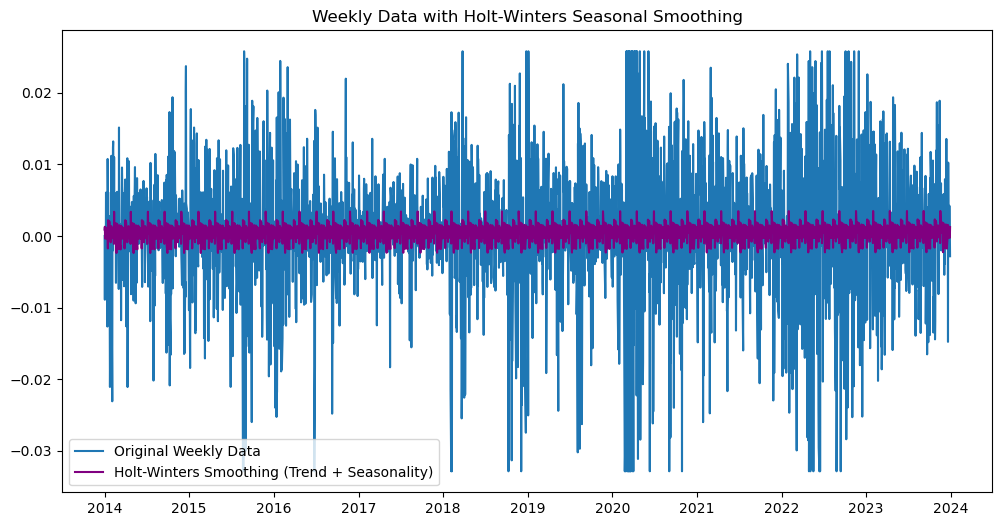

In [54]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Holt-Winters with weekly seasonality (assuming yearly cycle with a year seasonality)
hw_model = ExponentialSmoothing(log_diff_winso, trend='add', seasonal='add', seasonal_periods=52).fit()
hw_smoothed = hw_model.fittedvalues

# Plot the original data and the smoothed data
plt.figure(figsize=(12, 6))
plt.plot(log_diff_winso, label='Original Weekly Data')
plt.plot(hw_smoothed, color='purple', label='Holt-Winters Smoothing (Trend + Seasonality)')
plt.legend()
plt.title("Weekly Data with Holt-Winters Seasonal Smoothing")
plt.show()

In [55]:
# ADF Test
result = adfuller(log_diff_winso, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(log_diff_winso, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -14.652481434606488
p-value: 3.482735640310116e-27
Critial Values:
   1%, -3.4328724587241686
Critial Values:
   5%, -2.862654426799674
Critial Values:
   10%, -2.567363249505311

KPSS Statistic: 0.032800
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


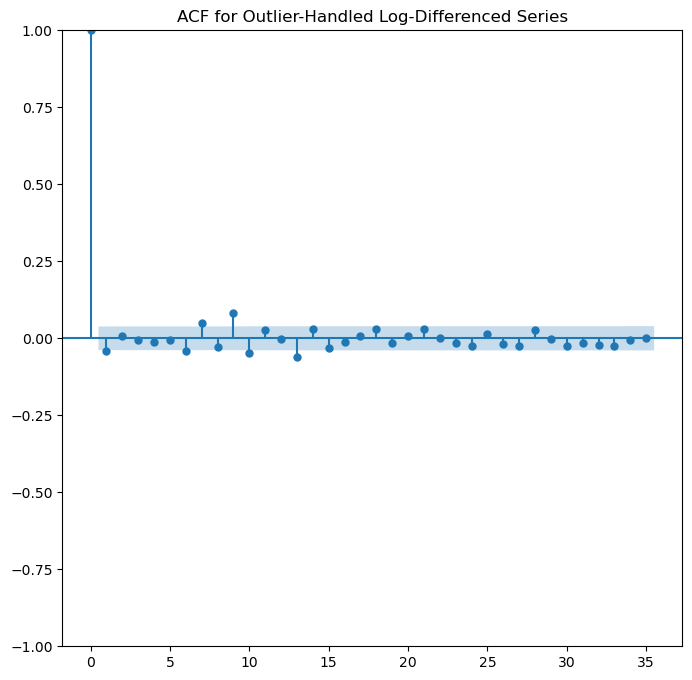

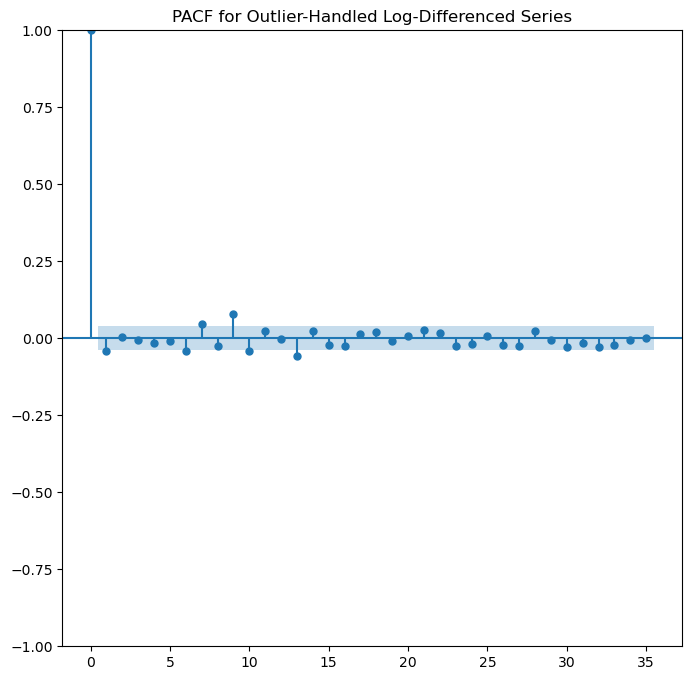

In [56]:
plot_acf(log_diff_winso.dropna())
plt.title("ACF for Outlier-Handled Log-Differenced Series")
plt.show()

plot_pacf(log_diff_winso.dropna())
plt.title("PACF for Outlier-Handled Log-Differenced Series")
plt.show()


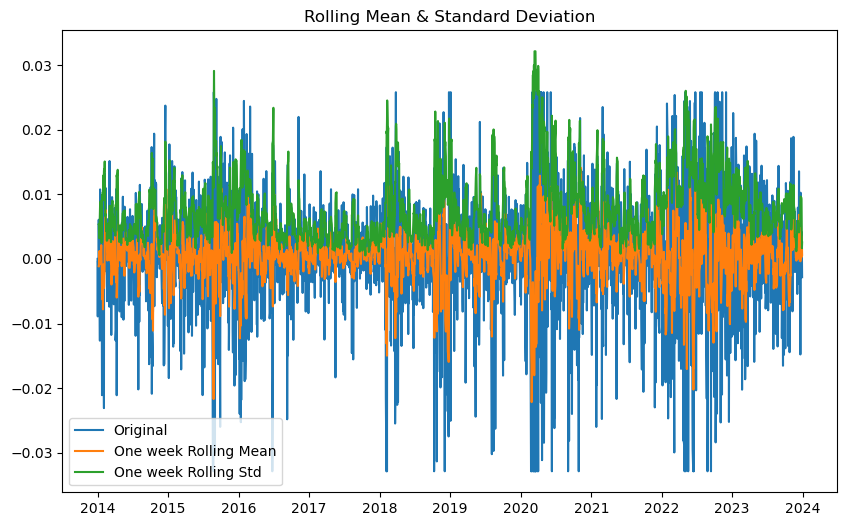

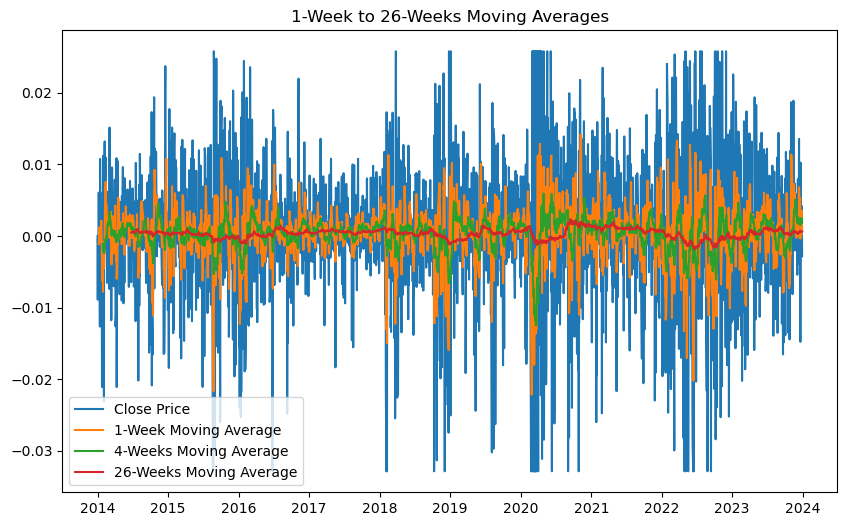

In [57]:
# Rolling Statistics and Moving Averages
rolling_mean_5 = log_diff_winso.rolling(window=5).mean()
rolling_std_5 = log_diff_winso.rolling(window=5).std()

# Long-term moving averages
rolling_mean_5 = log_diff_winso.rolling(window=5).mean()
rolling_mean_20 = log_diff_winso.rolling(window=20).mean()
rolling_mean_126 = log_diff_winso.rolling(window=126).mean()

# Visualizations

# Plotting rolling statistics
plt.figure(figsize=(10,6))
plt.plot(log_diff_winso, label='Original')
plt.plot(rolling_mean_5, label='One week Rolling Mean')
plt.plot(rolling_std_5, label='One week Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

# Plot moving averages
plt.figure(figsize=(10,6))
plt.plot(log_diff_winso, label='Close Price')
plt.plot(rolling_mean_5, label='1-Week Moving Average')
plt.plot(rolling_mean_20, label='4-Weeks Moving Average')
plt.plot(rolling_mean_126, label='26-Weeks Moving Average')
plt.title('1-Week to 26-Weeks Moving Averages')
plt.legend()
plt.show()

Seasonal Decomposition with Period = 252


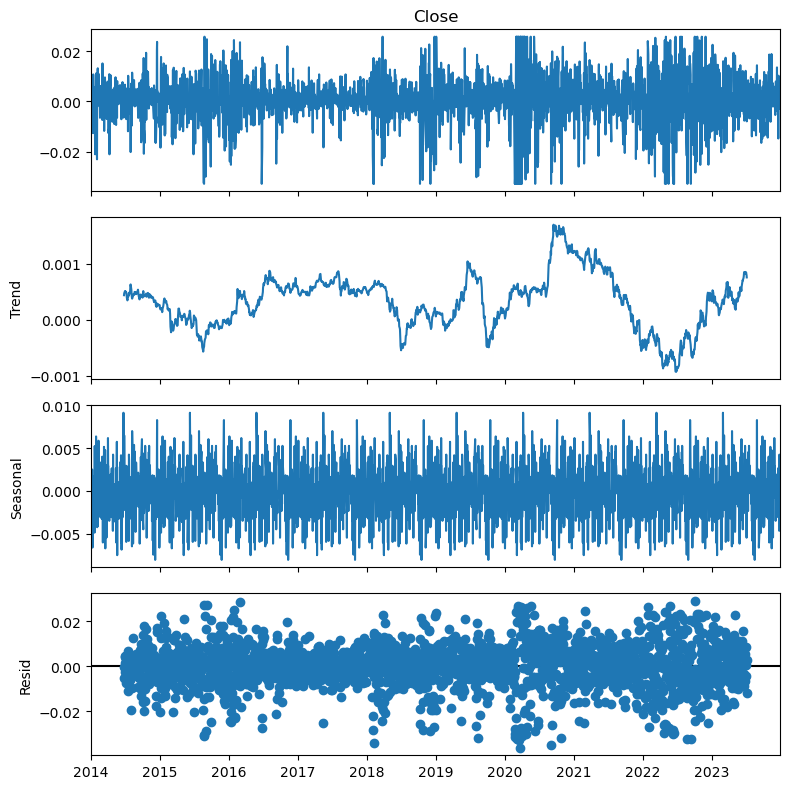

Seasonal Decomposition with Period = 126


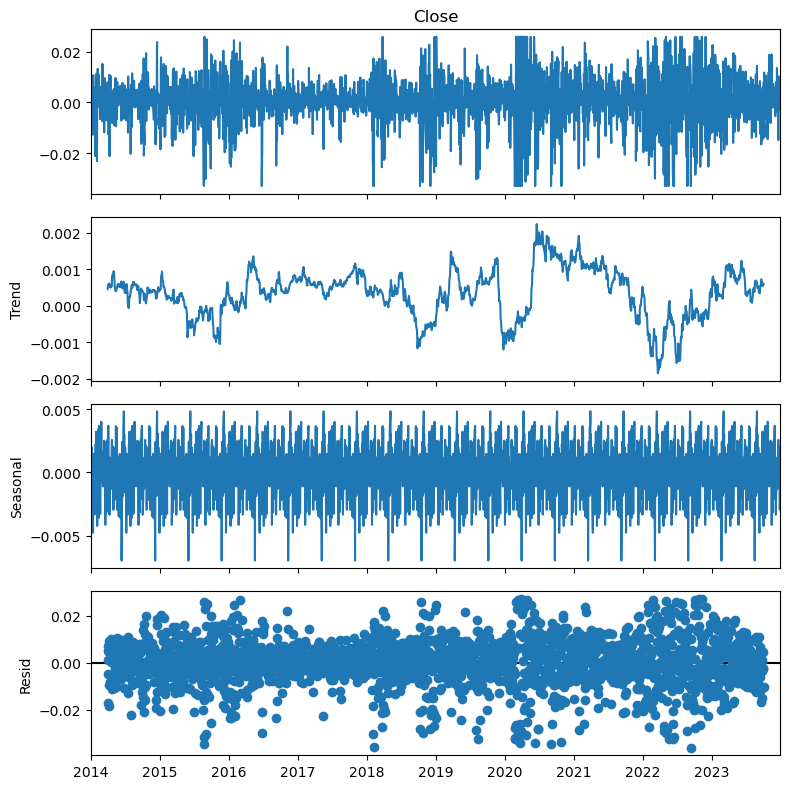

Seasonal Decomposition with Period = 20


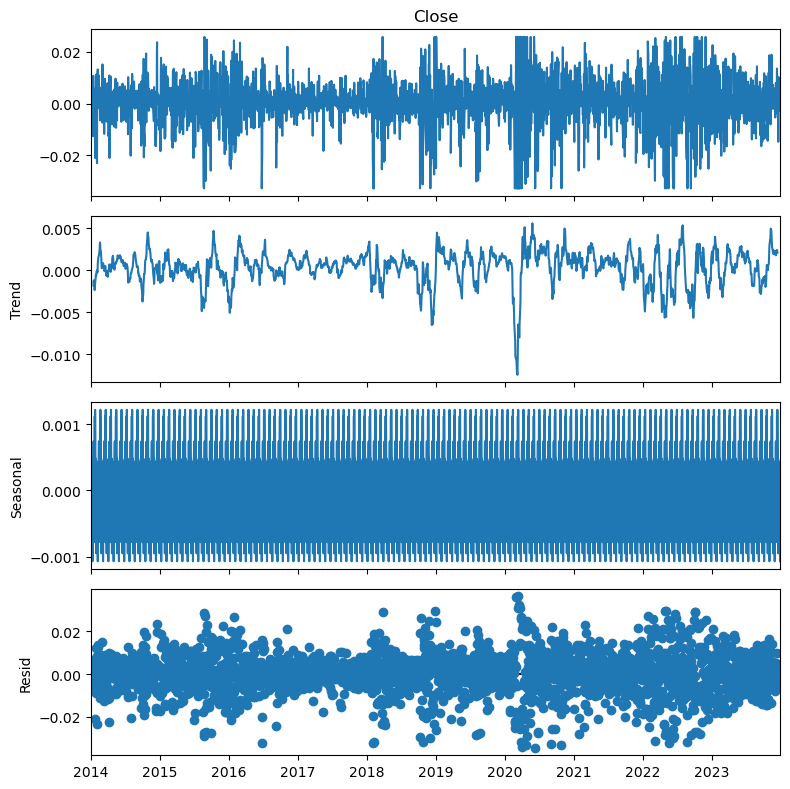

Seasonal Decomposition with Period = 5


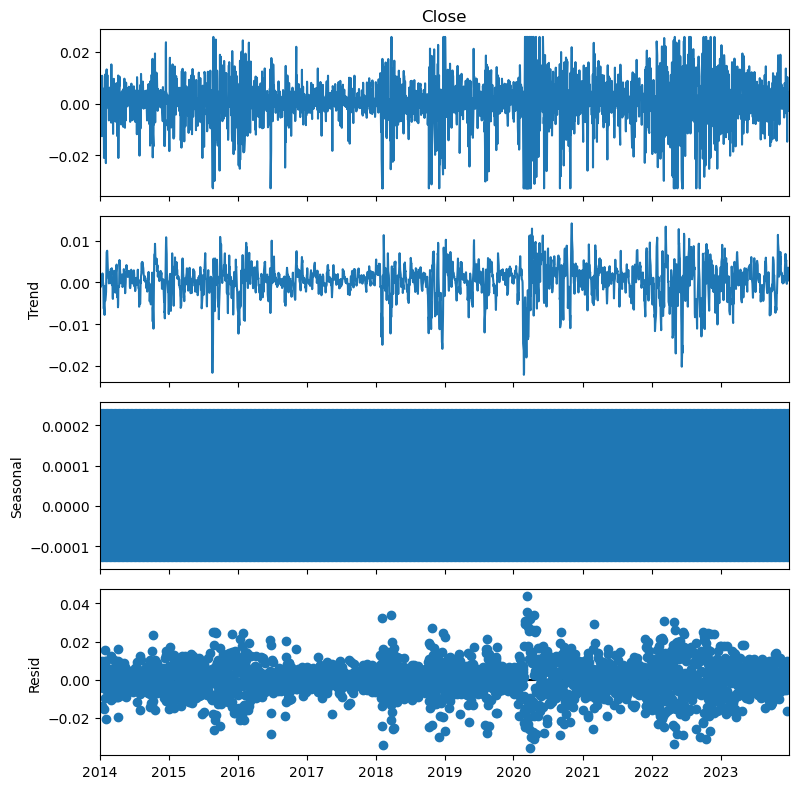

In [58]:
# Seasonal decompositions with different periods.
periods = [252, 126, 20, 5]  # Annual, Six-months, Quaterly and Monthly
# Function to generate the plots for all periods.
for period in periods:
    decompositions = seasonal_decompose(log_diff_winso, model='additive', period=period)

    # Plotting the components of the decomposition
    plt.rcParams.update({'figure.figsize': (8,8)})
    print(f"Seasonal Decomposition with Period = {period}")
    decompositions.plot()
    plt.show()

In [59]:
# 85-15 train-test split
# Determine the split indices
train_size = int(0.85 * len(log_diff_winso))
test_size = int(0.15 * len(log_diff_winso))

# Create train, and test sets
train = log_diff_winso[:train_size]
test = log_diff_winso[train_size:]
print("Training set size:", len(train))
print("Test set size:", len(test))

Training set size: 2216
Test set size: 392


In [60]:
# Auto-ARIMA with seasonal component
auto_model = auto_arima(train, seasonal=True, m=5, 
                        max_p=3, max_d=1, max_q=3,   # Limits on (p, d, q)
                        max_P=2, max_D=1, max_Q=2,  # Limits on (P, D, Q)
                        stepwise=True,               # Uses a stepwise search
                        trace=True, random_state=42, n_fits=50)                  # Display progress

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[5] intercept   : AIC=-14377.950, Time=4.15 sec
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=-14379.226, Time=0.58 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=-14382.449, Time=1.53 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=-14382.454, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=-14378.572, Time=0.37 sec
 ARIMA(0,0,1)(0,0,0)[5] intercept   : AIC=-14383.432, Time=0.73 sec
 ARIMA(0,0,1)(1,0,0)[5] intercept   : AIC=-14382.302, Time=0.75 sec
 ARIMA(0,0,1)(1,0,1)[5] intercept   : AIC=-14382.760, Time=1.13 sec
 ARIMA(1,0,1)(0,0,0)[5] intercept   : AIC=-14381.684, Time=0.61 sec
 ARIMA(0,0,2)(0,0,0)[5] intercept   : AIC=-14381.763, Time=0.59 sec
 ARIMA(1,0,0)(0,0,0)[5] intercept   : AIC=-14383.564, Time=0.48 sec
 ARIMA(1,0,0)(0,0,1)[5] intercept   : AIC=-14382.609, Time=0.62 sec
 ARIMA(1,0,0)(1,0,1)[5] intercept   : AIC=-14382.906, Time=1.50 sec
 ARIMA(2,0,0)(0,0,0)[5] intercept   : AIC=-14381.728, Time=0.79 sec
 ARIM

In [61]:
# Auto-ARIMA with seasonal component
auto_model = auto_arima(train, seasonal=True, m=20, 
                        max_p=3, max_d=1, max_q=3,   # Limits on (p, d, q)
                        max_P=2, max_D=1, max_Q=2,  # Limits on (P, D, Q)
                        stepwise=True,               # Uses a stepwise search
                        trace=True, random_state=42, n_fits=50)                  # Display progress

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[20] intercept   : AIC=-14373.725, Time=9.08 sec
 ARIMA(0,0,0)(0,0,0)[20] intercept   : AIC=-14379.226, Time=0.54 sec
 ARIMA(1,0,0)(1,0,0)[20] intercept   : AIC=-14381.759, Time=4.39 sec
 ARIMA(0,0,1)(0,0,1)[20] intercept   : AIC=-14381.613, Time=2.90 sec
 ARIMA(0,0,0)(0,0,0)[20]             : AIC=-14378.572, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[20] intercept   : AIC=-14383.564, Time=0.42 sec
 ARIMA(1,0,0)(0,0,1)[20] intercept   : AIC=-14381.740, Time=2.39 sec
 ARIMA(1,0,0)(1,0,1)[20] intercept   : AIC=-14379.722, Time=9.50 sec
 ARIMA(2,0,0)(0,0,0)[20] intercept   : AIC=-14381.728, Time=0.78 sec
 ARIMA(1,0,1)(0,0,0)[20] intercept   : AIC=-14381.684, Time=0.59 sec
 ARIMA(0,0,1)(0,0,0)[20] intercept   : AIC=-14383.432, Time=0.80 sec
 ARIMA(2,0,1)(0,0,0)[20] intercept   : AIC=-14379.216, Time=0.88 sec
 ARIMA(1,0,0)(0,0,0)[20]             : AIC=-14382.613, Time=0.33 sec

Best model:  ARIMA(1,0,0)(0,0,0)[20] intercept
Total fit ti

In [62]:
# Define the parameter grid for SARIMA
param_grid = {
    'p': [0, 1, 2, 3],        # Possible values for AR term
    'd': [0, 1],              # Possible values for differencing term
    'q': [0, 1, 2, 3],        # Possible values for MA term
    'P': [0, 1, 2],           # Seasonal AR term
    'D': [0, 1],              # Seasonal differencing
    'Q': [0, 1, 2],           # Seasonal MA term
    'm': [5]                 # Seasonal period (52 for weekly data with yearly seasonality)
}

# Number of random combinations to try
n_iter_search = 30  # Adjust based on computational resources

# Generate random parameter combinations
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Function to evaluate SARIMA model and return RMSE on test set
def evaluate_sarima_rmse(params):
    """
    Fits a SARIMA model with specified parameters and returns RMSE on the test set.
    """
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    try:
        # Fit SARIMA model on the training set
        model = sm.tsa.statespace.SARIMAX(train,
                                          order=(p, d, q),
                                          seasonal_order=(P, D, Q, m),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        result = model.fit(disp=False)

        # Forecast on the test set
        forecast = result.get_forecast(steps=len(test)).predicted_mean

        # Calculate RMSE between forecast and actual test values
        rmse = mean_squared_error(test, forecast, squared=False)
        return rmse
    except Exception as e:
        print(f"Failed to fit model for parameters {params}: {e}")
        return np.inf  # Use a large error value if fitting fails

# Initialize variables to store the best parameters and lowest RMSE
best_rmse = np.inf
best_params = None

# Loop over each set of parameters in the random sample
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}")
    
    # Evaluate the SARIMA model for the current parameter combination
    rmse = evaluate_sarima_rmse(params)
    
    # Track the best performing parameters and RMSE
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

    print(f"RMSE: {rmse}")

# Output the best parameters and the best RMSE score
print(f"Best parameters: {best_params}")
print(f"Best RMSE on test set: {best_rmse}")

Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 5, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}
RMSE: 0.010141224582230664
Testing SARIMA parameters: {'q': 2, 'p': 1, 'm': 5, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}
RMSE: 0.010125074522250234
Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 5, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}
RMSE: 0.010141984873449325
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 5, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}
RMSE: 0.012615584231042063
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 5, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
RMSE: 0.0131658204168406
Testing SARIMA parameters: {'q': 0, 'p': 0, 'm': 5, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
RMSE: 0.20285574843250231
Testing SARIMA parameters: {'q': 3, 'p': 0, 'm': 5, 'd': 0, 'Q': 2, 'P': 2, 'D': 0}
RMSE: 0.01014161932241325
Testing SARIMA parameters: {'q': 1, 'p': 3, 'm': 5, 'd': 1, 'Q': 0, 'P': 0, 'D': 0}
RMSE: 0.010124751295706997
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 5, 'd': 1, 'Q': 2, 'P': 0, 'D': 0}
RMSE: 0.010136111288818384
Testi

Mean Squared Error (MSE): 0.0001025105887999205
Training RMSE: 0.009427896220840264
Test RMSE: 0.010124751295706997
Mean Absolute Error (MAE): 0.007686891520033479
Mean Absolute Percentage Error (MAPE): inf %


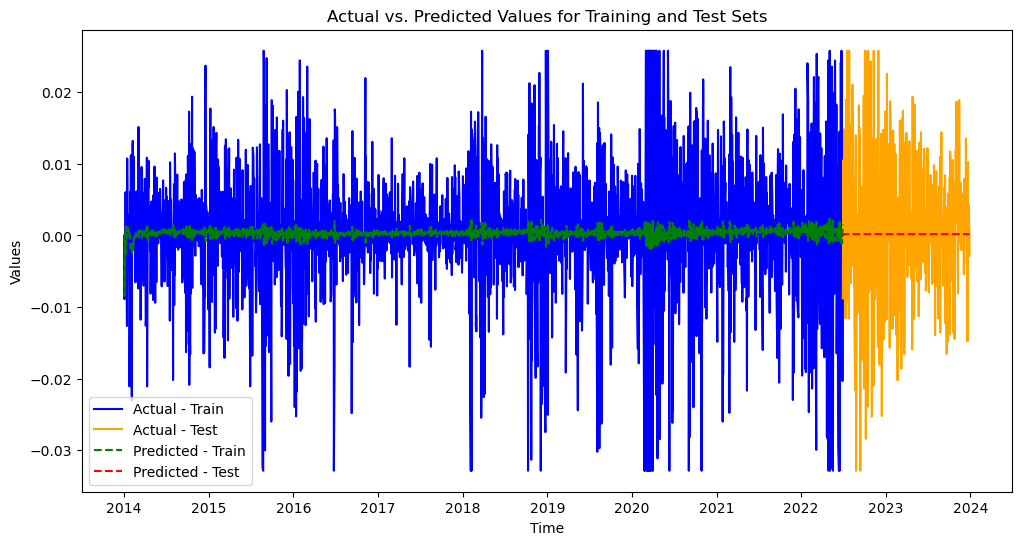

In [63]:
# Fit SARIMA model with the best parameters on the training set
sarima_final = sm.tsa.statespace.SARIMAX(train,
                                         order=(best_params['p'], best_params['d'], best_params['q']),
                                         seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['m']),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
sarima_final_fitted = sarima_final.fit(disp=False)

# Calculate RMSE on training data
train_predictions = sarima_final_fitted.predict(start=0, end=len(train)-1)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate RMSE on test data
test_predictions = sarima_final_fitted.forecast(steps=len(test))
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate additional evaluation metrics
mse = mean_squared_error(test, test_predictions)
mae = mean_absolute_error(test, test_predictions)

# Calculate MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test, test_predictions)

# Print evaluation metrics
print("Mean Squared Error (MSE):", mse)
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")

# Plot the actual vs. predicted values for training and test sets
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [ ]:
# Define the parameter grid for SARIMA
param_grid = {
    'p': [0, 1, 2, 3],        # Possible values for AR term
    'd': [0, 1],              # Possible values for differencing term
    'q': [0, 1, 2, 3],        # Possible values for MA term
    'P': [0, 1, 2],           # Seasonal AR term
    'D': [0, 1],              # Seasonal differencing
    'Q': [0, 1, 2],           # Seasonal MA term
    'm': [20]                 # Seasonal period (52 for weekly data with yearly seasonality)
}

# Number of random combinations to try
n_iter_search = 5  # Adjust based on computational resources

# Generate random parameter combinations
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Function to evaluate SARIMA model and return RMSE on test set
def evaluate_sarima_rmse(params):
    """
    Fits a SARIMA model with specified parameters and returns RMSE on the test set.
    """
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    try:
        # Fit SARIMA model on the training set
        model = sm.tsa.statespace.SARIMAX(train,
                                          order=(p, d, q),
                                          seasonal_order=(P, D, Q, m),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        result = model.fit(disp=False)

        # Forecast on the test set
        forecast = result.get_forecast(steps=len(test)).predicted_mean

        # Calculate RMSE between forecast and actual test values
        rmse = mean_squared_error(test, forecast, squared=False)
        return rmse
    except Exception as e:
        print(f"Failed to fit model for parameters {params}: {e}")
        return np.inf  # Use a large error value if fitting fails

# Initialize variables to store the best parameters and lowest RMSE
best_rmse = np.inf
best_params = None

# Loop over each set of parameters in the random sample
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}")
    
    # Evaluate the SARIMA model for the current parameter combination
    rmse = evaluate_sarima_rmse(params)
    
    # Track the best performing parameters and RMSE
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

    print(f"RMSE: {rmse}")

# Output the best parameters and the best RMSE score
print(f"Best parameters: {best_params}")
print(f"Best RMSE on test set: {best_rmse}")

Testing SARIMA parameters: {'q': 2, 'p': 1, 'm': 20, 'd': 0, 'Q': 0, 'P': 1, 'D': 0}
RMSE: 0.010131021993019561
Testing SARIMA parameters: {'q': 3, 'p': 0, 'm': 20, 'd': 1, 'Q': 1, 'P': 1, 'D': 1}


In [ ]:
# Fit SARIMA model with the best parameters on the training set
sarima_final = sm.tsa.statespace.SARIMAX(train,
                                         order=(best_params['p'], best_params['d'], best_params['q']),
                                         seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['m']),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
sarima_final_fitted = sarima_final.fit(disp=False)

# Calculate RMSE on training data
train_predictions = sarima_final_fitted.predict(start=0, end=len(train)-1)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate RMSE on test data
test_predictions = sarima_final_fitted.forecast(steps=len(test))
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate additional evaluation metrics
mse = mean_squared_error(test, test_predictions)
mae = mean_absolute_error(test, test_predictions)

# Calculate MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test, test_predictions)

# Print evaluation metrics
print("Mean Squared Error (MSE):", mse)
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")

# Plot the actual vs. predicted values for training and test sets
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [ ]:
# Define the train-test split indices for time-series cross-validation
n_splits = 5
test_window = 100  # Number of rows for each test set
initial_train_window = len(train) - n_splits * test_window

# Parameter grid and random sampling as defined in your prompt
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [5]
}

n_iter_search = 30  # Number of random parameter combinations
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Updated function to evaluate SARIMA with cross-validation (no exogenous variables)
def evaluate_sarima_cv_rmse(params):
    """
    Performs rolling cross-validation on SARIMA model with specified parameters and returns average RMSE.
    """
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rmse_scores = []  # Store RMSE for each fold
    
    for i in range(n_splits):
        # Define the train and test indices for this fold
        train_end = initial_train_window + i * test_window
        test_end = train_end + test_window
        
        y_train, y_test = train[:train_end], train[train_end:test_end]
        
        try:
            # Fit SARIMA model on the current training set
            model = sm.tsa.statespace.SARIMAX(y_train,
                                              order=(p, d, q),
                                              seasonal_order=(P, D, Q, m),
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            result = model.fit(disp=False)

            # Forecast on the current test set
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
            
            # Calculate RMSE for this fold
            rmse = mean_squared_error(y_test, forecast, squared=False)
            rmse_scores.append(rmse)
        except Exception as e:
            print(f"Failed to fit model for parameters {params} on fold {i+1}: {e}")
            return np.inf  # Return large RMSE if fitting fails for this parameter set
    
    # Calculate the average RMSE across all folds
    avg_rmse = np.mean(rmse_scores)
    return avg_rmse

# Initialize variables to store the best parameters and lowest average RMSE
best_rmse = np.inf
best_params = None

# Perform random search with cross-validation
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}")
    
    # Evaluate SARIMA model with cross-validation
    rmse = evaluate_sarima_cv_rmse(params)
    
    # Track the best performing parameters and RMSE
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

    print(f"Average RMSE across folds: {rmse}")

# Output the best parameters and the best RMSE score
print(f"Best parameters: {best_params}")
print(f"Best average RMSE across folds: {best_rmse}")

In [ ]:
window_size = 200  # Fixed training window size
test_size = 100  # Fixed test window size
rolling_rmses = []

for i in range(0, len(train) - window_size - test_size, test_size):
    y_train = train[i:i + window_size]
    y_test = train[i + window_size:i + window_size + test_size]

    # Fit the model and calculate RMSE
    try:
        # Initialize SARIMAX model without exogenous variables
        model = sm.tsa.statespace.SARIMAX(y_train, order=(1, 0, 2), seasonal_order=(1, 0, 0, 5))
        result = model.fit(disp=False)

        # Forecast on the test set without exogenous variables
        forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
        
        # Calculate RMSE for this rolling window
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        rolling_rmses.append(rmse)
    except Exception as e:
        print(f"Failed to fit model on iteration {i}: {e}")
        rolling_rmses.append(np.inf)  # Assign high error if model fitting fails

# Calculate the average RMSE across all rolling windows
avg_rolling_rmse = np.mean(rolling_rmses)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

In [ ]:
# Define the train-test split indices for time-series cross-validation
n_splits = 5
test_window = 100  # Number of rows for each test set
initial_train_window = len(train) - n_splits * test_window

# Parameter grid and random sampling as defined in your prompt
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [20]
}

n_iter_search = 30  # Number of random parameter combinations
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Updated function to evaluate SARIMA with cross-validation (no exogenous variables)
def evaluate_sarima_cv_rmse(params):
    """
    Performs rolling cross-validation on SARIMA model with specified parameters and returns average RMSE.
    """
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rmse_scores = []  # Store RMSE for each fold
    
    for i in range(n_splits):
        # Define the train and test indices for this fold
        train_end = initial_train_window + i * test_window
        test_end = train_end + test_window
        
        y_train, y_test = train[:train_end], train[train_end:test_end]
        
        try:
            # Fit SARIMA model on the current training set
            model = sm.tsa.statespace.SARIMAX(y_train,
                                              order=(p, d, q),
                                              seasonal_order=(P, D, Q, m),
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            result = model.fit(disp=False)

            # Forecast on the current test set
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
            
            # Calculate RMSE for this fold
            rmse = mean_squared_error(y_test, forecast, squared=False)
            rmse_scores.append(rmse)
        except Exception as e:
            print(f"Failed to fit model for parameters {params} on fold {i+1}: {e}")
            return np.inf  # Return large RMSE if fitting fails for this parameter set
    
    # Calculate the average RMSE across all folds
    avg_rmse = np.mean(rmse_scores)
    return avg_rmse

# Initialize variables to store the best parameters and lowest average RMSE
best_rmse = np.inf
best_params = None

# Perform random search with cross-validation
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}")
    
    # Evaluate SARIMA model with cross-validation
    rmse = evaluate_sarima_cv_rmse(params)
    
    # Track the best performing parameters and RMSE
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

    print(f"Average RMSE across folds: {rmse}")

# Output the best parameters and the best RMSE score
print(f"Best parameters: {best_params}")
print(f"Best average RMSE across folds: {best_rmse}")

In [ ]:
window_size = 200  # Fixed training window size
test_size = 100  # Fixed test window size
rolling_rmses = []

for i in range(0, len(train) - window_size - test_size, test_size):
    y_train = train[i:i + window_size]
    y_test = train[i + window_size:i + window_size + test_size]

    # Fit the model and calculate RMSE
    try:
        # Initialize SARIMAX model without exogenous variables
        model = sm.tsa.statespace.SARIMAX(y_train, order=(1, 0, 2), seasonal_order=(1, 0, 0, 20))
        result = model.fit(disp=False)

        # Forecast on the test set without exogenous variables
        forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
        
        # Calculate RMSE for this rolling window
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        rolling_rmses.append(rmse)
    except Exception as e:
        print(f"Failed to fit model on iteration {i}: {e}")
        rolling_rmses.append(np.inf)  # Assign high error if model fitting fails

# Calculate the average RMSE across all rolling windows
avg_rolling_rmse = np.mean(rolling_rmses)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

In [ ]:
# Saving dataframe to the Desktop to initiate trials with new features. 
log_diff_winso.to_csv('C:/Users/nozom/OneDrive/Desktop/Preprocessing Pipelines/df_log_diff_daily.csv', index=True)

In [ ]:
df1.describe()

- The code for volatility (Rolling Standard Deviation) was generating numerous NaN values and this could be due to the scale of the log returns. Thus, the Exponential Weighted Volatility will be used as variables. 

In [ ]:
# Calculate moving averages and volatility before winsorization
df1['MA5'] = df1['Close'].rolling(window=5).mean()
df1['MA21'] = df1['Close'].rolling(window=21).mean()
df1['volatility_5_ewm'] = df1['Close'].ewm(span=5, adjust=False).std()
df1['volatility_21_ewm'] = df1['Close'].ewm(span=21, adjust=False).std()

# 5-day and 21-day Exponential Moving Averages
df1['EMA_5'] = df1['Close'].ewm(span=5, adjust=False).mean()
df1['EMA_21'] = df1['Close'].ewm(span=21, adjust=False).mean()

# 10-day Momentum (Rate of Change)
df1['momentum_10'] = df1['Close'].diff(10)

# Calculate log returns
df1['log_return'] = np.log(df1['Close'] / df1['Close'].shift(1))

# Technical indicators like RSI and MACD
delta = df1['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=10).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=10).mean()
rs = gain / loss
df1['rsi'] = 100 - (100 / (1 + rs))

# Display the DataFrame to check the results
display(df1)

In [ ]:
# Check for missing values.
missing_values = df1.isnull().sum()

# Print the number of missing values for each column.
print("Missing values:")
print(missing_values)

In [ ]:
# Drop rows where any column has NaN values
df1 = df1.dropna()

# Check for missing values.
missing_values = df1.isnull().sum()

# Print the number of missing values for each column.
print("Missing values:")
print(missing_values)

In [ ]:
df1.describe()

In [ ]:
# List of features to check for outliers
features = ['Close', 'log_return', 'MA5', 'MA21', 'volatility_5_ewm', 'volatility_21_ewm', 'momentum_10', 'EMA_5', 'EMA_21']

# Create boxplots for each feature
plt.figure(figsize=(16, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i) # 3x3 grid for 9 features
    sns.boxplot(data=df1, x='Year', y=feature)
    plt.title(f'Boxplot of {feature}')
    
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df1[['Close', 'log_return', 'MA5', 'MA21', 'volatility_5_ewm', 'volatility_21_ewm', 'momentum_10', 'EMA_5', 'EMA_21']].corr()

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Exogenous Features')
plt.show()

In [ ]:
# Calculate the correlation between features and the target (Close price)
feature_target_corr = df1[['Close', 'log_return', 'MA5', 'MA21', 'volatility_5_ewm', 'volatility_21_ewm', 'momentum_10', 'EMA_5', 'EMA_21']].corr()

# Display only the target's correlation with the other features
print(feature_target_corr['Close'])

- The Variance Inflation Factor (VIF) will help the measure the level of multicollinearity among the features extracted from the series. It will show how strong or weak certain feature is correlated to other features.
The VIF values:
- Equal to one will have no multicollinearity.
- Between 1 and 5 will present moderate level. 
- Between 5 and 10 normally will indicate multicollinearity.
- Above 10 very strong.  

In [ ]:
# Create a DataFrame for features only
features = df1[['Close', 'log_return', 'MA5', 'MA21', 'volatility_5_ewm', 'volatility_21_ewm', 'momentum_10', 'EMA_5', 'EMA_21']]

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = features.columns
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print(vif)

The VIF values of the dataset shows that: 
- Moving Averages (MA5, MA21, EMA_5 and EMA_21) will be naturally correlated with the S&P500 index (Close) and this is because they are derivered from indexes.
- Volatility has a high score of 10 (keeping both could be redundant for ML models.
- Log Returns: The calculation is based on the relative change of the index so it is less likely to be correlated with the Close values (Score that falls under "good" feature to be added to the model.
- Momentum: Another feature that has a score that presents a moderate level, which can be useful for models.

After analysing the correlation between the features: 
- Moving Averages: All of the features (MA5, MA21, EMA_5 and EMA_21) will be excluded from the set due to strong multicollinearity.
- Volatility: The (5 and 21) has similiar score but the (5) has a small difference, thus the (21) will also be excluded since they represent the same "indicator".
- Log Returns and Momentum are the feature with lowest levels of correlation, so they can be very useful for predicting models. 

In [ ]:
# Keep only the necessary features
df1 = df1[['Year', 'Close', 'log_return', 'volatility_5_ewm', 'momentum_10']]

# Display the modified DataFrame
print(df1.head())

In [ ]:
# List of features to check for outliers
features = ['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']

# Create boxplots for each feature
plt.figure(figsize=(16, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i) # 2x2 grid for 4 features
    sns.boxplot(data=df1, x='Year', y=feature)
    plt.title(f'Boxplot of {feature}')
    
plt.tight_layout()
plt.show()

In [ ]:
# List of features to plot histograms for
features = ['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']

# Plot histograms for each feature
plt.figure(figsize=(12, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)  # 2x2 grid for 4 features
    sns.histplot(df1[feature], bins=30, kde=True)
    plt.title(f'Histogram of {feature}')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df1[['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']].corr()

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Exogenous Features')
plt.show()

# Calculate the correlation between features and the target (Close price)
feature_target_corr = df1[['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']].corr()

# Display only the target's correlation with the other features
print(feature_target_corr['Close'])

In [ ]:
# Saving dataframe to the Desktop to initiate trials with new features. 
df1.to_csv('C:/Users/nozom/OneDrive/Desktop/Preprocessing Pipelines/df_feat.csv', index=True)

### Winsorization

- An attempt to handle outliers and reduce volatility applying only winsorization, however LSTM models were still overfitting as observable in the winzo Log Returns NN's Notebook. Thus, winsorization will be perfomed on the raw data so as its features.

After the winsorization is applied, further EDA and correlation analysis will be performed to check the impact in the data.

In [ ]:
# Creates a copy to have the original to compare 
df_winso_feat = df1.copy()

# Function to apply winsorization per year for each feature
def winsorize_year(df_winso_feat, features, lower_quantile=0.1, upper_quantile=0.9):
    # Loop through each feature and apply winsorization
    for feature in features:
        df_winso_feat[feature] = df_winso_feat.groupby('Year')[feature].transform(
            lambda x: x.clip(lower=x.quantile(lower_quantile), upper=x.quantile(upper_quantile))
        )
    return df_winso_feat

# List of features to apply winsorization
features = ['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']

# Apply winsorization to each feature per year
df_winso_feat = winsorize_year(df_winso_feat, features)

# Print a sample of the winsorized DataFrame
print(df_winso_feat.head())

In [ ]:
# Select only the relevant columns to describe from df1 (before Winsorization)
before_winsor = df1[['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']].describe()

# Select the same columns from df_winso_feat (after Winsorization)
after_winsor = df_winso_feat[['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']].describe()

# Display both summaries to compare
print("Statistics Before Winsorization:")
print(before_winsor)

print("\nStatistics After Winsorization:")
print(after_winsor)

The descriptive statistics shows that: 
- The index (Close) had minimal changes, where its minimun ranges from 1845 to 4668.
- Log returns have a different standard deviation (reduced from 0.01 to 0.007). Also, the feature presents a new range (min =  -0.12765, max = 0.08968)(min = -0.01863, max = 0.01874). Showing that the winsorization performed well on the feature.
- THe Volatility had a big impact from the approach, reducing its maximun value from 236 to 100.
- Momentum had the min/max adjusted (From: -732 / 426 To: -263 / 194), the standard deviation also reduced from 101 to 79. Thus, making the feature more stable.  

In [ ]:
# List of features to check for outliers
features = ['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']

# Create boxplots for each feature
plt.figure(figsize=(16, 12))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i) # 2x2 grid for 4 features
    sns.boxplot(data=df_winso_feat, x='Year', y=feature)
    plt.title(f'Boxplot of {feature}')
    
plt.tight_layout()
plt.show()

- The S&P500 Index had numerous outliers over the ten years period, especially during 2020 (huge spikes). After winsorization, the index did not suffered major changes at the boxplot nor the distribution,
- The Log Returns had a major impact regarding outliers, before the approach numerous were present, but after not only they were capped but also presents "better" distribution.
- The Volatility also had the outliers clipped and they are no longer present.
- The Momentum also had their outliers reduced.

In [ ]:
# List of features to plot histograms for
features = ['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']

# Plot histograms for each feature
plt.figure(figsize=(12, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)  # 2x2 grid for 4 features
    sns.histplot(df_winso_feat[feature], bins=30, kde=True)
    plt.title(f'Histogram of {feature}')

plt.tight_layout()
plt.show()


- Apart from the Index that stayed relatively the same, the features had their extreme values clipped and turned their distribution less tailed. This could help the removal of noise. 

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df_winso_feat[['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']].corr()

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Exogenous Features')
plt.show()

# Calculate the correlation between features and the target (Close price)
feature_target_corr = df_winso_feat[['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']].corr()

# Display only the target's correlation with the other features
print(feature_target_corr['Close'])

- The technique slightly increased the correlation between volatility and the stock index. Thus, in general the correlation scores remained the same. 

In [ ]:
# Create a DataFrame for features only
features = df_winso_feat[['Close', 'log_return', 'volatility_5_ewm', 'momentum_10']]

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = features.columns
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print(vif)

- Winsorization reduced the outliers in the features and reduced the VIF scores, indicating that the approach reduced multicollinearity among the features.

**After a couple of trials with raw data and transformed data using different LSTM archtectures, the final perfomance was indicating overfitting, not generalizing well. Thus, it is hoped that feature engineering will aid the models to capture the nuance of the data and improve its performance.** 

In [ ]:
# Saving dataframe to the Desktop to initiate trials with new features. 
df_winso_feat.to_csv('C:/Users/nozom/OneDrive/Desktop/Preprocessing Pipelines/df_winso_feat.csv', index=True)